Write your post here.

In [103]:
from gplearn.genetic import SymbolicRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.random import check_random_state
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as pl
from matplotlib import rcParams
from IPython.display import Image
from scipy.io import loadmat
import pydotplus
from sklearn.metrics import mean_squared_error
from math import sqrt
% matplotlib inline

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [3]:
fpath ='/accounts/ekarakoy/DATA/OWT/nomad_rrs4clustering.mat'

In [4]:
matlabData = loadmat(fpath)

In [5]:
wavelength = matlabData['wl'][0]
rrsBelow = matlabData['rrs_below']
chl = matlabData['chl_nomad'] # I might use this as an additional feature in clustering

In [6]:
labels = list(wavelength) + ['chl']
df = pd.DataFrame(data=np.hstack((rrsBelow, chl)), columns=labels)

In [7]:
df.head()

,411,443,469,489,510,520,547,550,555,560,565,670,chl
0,0.002307,0.003225,0.004674,0.006265,0.007661,0.008944,0.012935,0.013410,0.014040,0.014715,0.015325,0.006588,38.19
1,0.002035,0.002650,0.003273,0.004149,0.004767,0.005416,0.007338,0.007570,0.007878,0.008208,0.008549,0.003241,35.01
2,0.001862,0.002271,0.002654,0.003523,0.004367,0.005147,0.007423,0.007691,0.008053,0.008434,0.008822,0.003084,26.91
3,0.002817,0.003330,0.004096,0.005482,0.006963,0.008243,0.012075,0.012525,0.013127,0.013770,0.014361,0.006154,47.96
4,0.001735,0.001959,0.002129,0.002882,0.003638,0.004115,0.005079,0.005191,0.005337,0.005507,0.005716,0.003423,23.55


Next, I'll make a new dataframe with just SeaWiFS-wavelength Rrs and chl and delete this superset to save space

In [8]:
swfWvl = [411, 443, 489, 510, 555, 670]

In [12]:
dfSwf = df.loc[:, swfWvl + ['chl']]
del df

In [15]:
dfSwf.head()

,411,443,489,510,555,670,chl
0,0.002307,0.003225,0.006265,0.007661,0.014040,0.006588,38.19
1,0.002035,0.002650,0.004149,0.004767,0.007878,0.003241,35.01
2,0.001862,0.002271,0.003523,0.004367,0.008053,0.003084,26.91
3,0.002817,0.003330,0.005482,0.006963,0.013127,0.006154,47.96
4,0.001735,0.001959,0.002882,0.003638,0.005337,0.003423,23.55


In [16]:
dfSwf.describe()

,411,443,489,510,555,670,chl
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,0.009913,0.009351,0.009086,0.007638,0.006105,0.001289,1.544312
std,0.006548,0.005329,0.004598,0.004656,0.006091,0.002629,4.002408
min,0.000098,0.000365,0.000546,0.000502,0.000398,0.000023,0.000000
25%,0.005000,0.005335,0.006135,0.005511,0.003029,0.000196,0.054000
50%,0.007967,0.008120,0.008528,0.006562,0.003970,0.000385,0.301200
75%,0.013895,0.012699,0.011118,0.007965,0.006047,0.001101,1.218750
max,0.039485,0.031489,0.046573,0.050136,0.060087,0.031832,72.120000


What is this '0-chl' business?

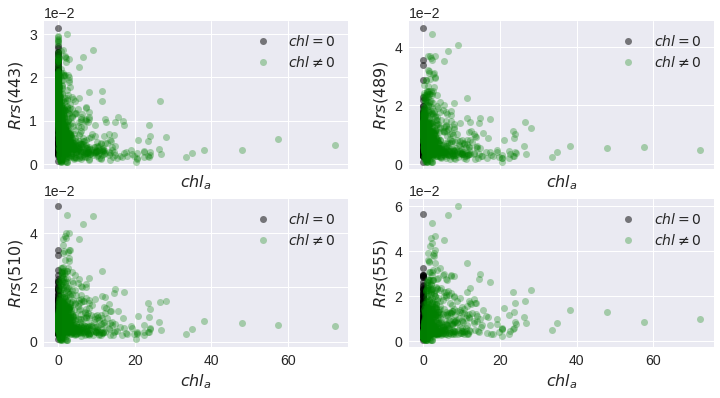

In [17]:
f,axs = pl.subplots(nrows=2, ncols=2, figsize=(12,6), sharex=True)
for band, ax in zip([443, 489, 510, 555], axs.ravel()):
    ax.plot(dfSwf.loc[dfSwf.chl==0, 'chl'], dfSwf.loc[dfSwf.chl==0, band],
            'ko',alpha=0.5, label=r'$chl=0$')
    ax.plot(dfSwf.loc[dfSwf.chl!=0, 'chl'], dfSwf.loc[dfSwf.chl!=0, band],
            'go', alpha=0.3,label=r'$chl \neq 0$')
    ax.legend(loc='best', fontsize=14);
    ax.set_xlabel('$chl_a$', fontsize=16)
    ax.set_ylabel('$Rrs(%d)$' % band, fontsize=16)

So the data where chl is 0 looks funky to me as this does not seem to pop up in the Rrs data. So for now I'll drop that part of the data so as to avoid giving the algorithm a hard time.

In [18]:
dfSwf['chl'].replace(0,np.NaN, inplace=True)

In [19]:
dfSwf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 7 columns):
411    2404 non-null float64
443    2404 non-null float64
489    2404 non-null float64
510    2404 non-null float64
555    2404 non-null float64
670    2404 non-null float64
chl    1874 non-null float64
dtypes: float64(7)
memory usage: 131.5 KB


In [21]:
dfSwf.dropna(inplace=True)

In [22]:
dfSwf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1874 entries, 0 to 2403
Data columns (total 7 columns):
411    1874 non-null float64
443    1874 non-null float64
489    1874 non-null float64
510    1874 non-null float64
555    1874 non-null float64
670    1874 non-null float64
chl    1874 non-null float64
dtypes: float64(7)
memory usage: 117.1 KB


In [23]:
dfSwf['maxBlue'] = dfSwf.loc[:,[443, 490, 510]].max(axis=1)

In [24]:
dfSwf.head()

,411,443,489,510,555,670,chl,maxBlue
0,0.002307,0.003225,0.006265,0.007661,0.014040,0.006588,38.19,0.007661
1,0.002035,0.002650,0.004149,0.004767,0.007878,0.003241,35.01,0.004767
2,0.001862,0.002271,0.003523,0.004367,0.008053,0.003084,26.91,0.004367
3,0.002817,0.003330,0.005482,0.006963,0.013127,0.006154,47.96,0.006963
4,0.001735,0.001959,0.002882,0.003638,0.005337,0.003423,23.55,0.003638


In [25]:
dfSwf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1874 entries, 0 to 2403
Data columns (total 8 columns):
411        1874 non-null float64
443        1874 non-null float64
489        1874 non-null float64
510        1874 non-null float64
555        1874 non-null float64
670        1874 non-null float64
chl        1874 non-null float64
maxBlue    1874 non-null float64
dtypes: float64(8)
memory usage: 131.8 KB


In [26]:
dfSwf.describe()

,411,443,489,510,555,670,chl,maxBlue
count,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000,1874.000000
mean,0.009530,0.009077,0.009043,0.007704,0.006241,0.001313,1.981071,0.010267
std,0.006295,0.005162,0.004693,0.004811,0.006245,0.002590,4.436948,0.005792
min,0.000098,0.000365,0.000546,0.000502,0.000398,0.000023,0.012000,0.000502
25%,0.004957,0.005256,0.006091,0.005467,0.003056,0.000193,0.182000,0.006106
50%,0.007836,0.007967,0.008436,0.006548,0.004011,0.000385,0.604500,0.008981
75%,0.013161,0.012172,0.010946,0.008140,0.006390,0.001151,1.644000,0.013220
max,0.039485,0.029934,0.044280,0.046735,0.060087,0.031832,72.120000,0.046735


No cleanup necessary but we need to bring stuff to a similar scale.
I'll try two ways: taking the lognormal (e.g. Campbell *et al.*, '94(?), which will agree with the OC4 formulation anyway) The other is to standardize the data.
I'll try both and see what I come up with.
First, I'll do the log transform and run the model.

In [31]:
Xlog = np.log10(dfSwf.loc[:,swfWvl ])
ylog = np.log10(dfSwf.loc[:,'chl']+1e-7)

In [32]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(Xlog, ylog,
                                           test_size=0.33)

In [33]:
def CI(df):
    # assumes df has rrs data at specific wavelengths
    blue, green, red=443, 555, 670
    ci = df[green] - (df[blue] + (green - blue) / (red - blue) * (df[red] - df[blue]))
    return ci

In [36]:
def OC4(rrsMaxBlue, rrsGreen, log=True):
    # maxblue is last column of rrsData
    # note the log option to specify whether the data has already been log transformed
    a=[0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
    if log:
        poly = np.sum([a[i]*np.power((rrsMaxBlue - rrsGreen),i)
                       for i in range(1,5) ], axis=0)
    else:
        poly = np.sum([a[i]*np.power(np.log10(rrsMaxBlue/rrsGreen),i )
                       for i in range(1,5) ], axis=0)
    poly+=a[0]
    chl = np.power(10,poly)
    return chl

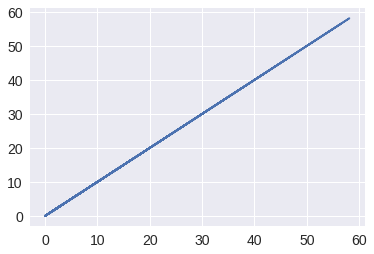

In [39]:
# making sure the log option in oc4 works
logchlMdl = OC4(np.log10(dfSwf.maxBlue.values), np.log10(dfSwf[green].values),
                  log=True)
chlMdl = OC4(dfSwf.maxBlue.values, dfSwf[green].values,log=False)
pl.plot(logchlMdl, chlMdl);

In [89]:
#X_train comes from X, which was log transformed, so...
green = 555
maxBlueTrainLog = X_train_log[[443, 489, 510]].max(axis=1)
chlOC4_train = OC4(maxBlueTrainLog.values, X_train_log[green].values, log=True)

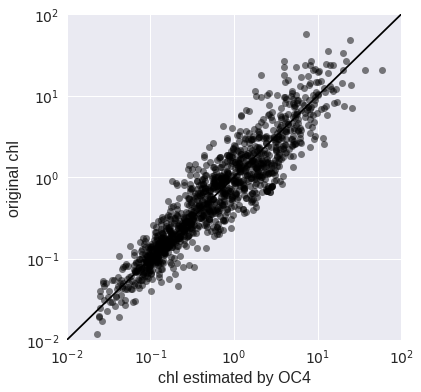

In [43]:
pl.figure(figsize=(6,6))
pl.plot(chl_train,np.power(10,y_train_log),'ko',alpha=0.5)
pl.yscale('log')
pl.ylim(1e-2,1e2)
pl.xlim(1e-2,1e2)
pl.xscale('log')
pl.plot([1e-2,1e2],[1e-2,1e2],'k')
pl.xlabel('chl estimated by OC4', fontsize=16)
pl.ylabel('original chl', fontsize=16);

In [55]:
est_gp = SymbolicRegressor(population_size=5000,const_range=(-5,5),
                           generations=30,transformer=True,
                           trigonometric=False,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.2,
                           max_samples=0.9, verbose=1, comparison=True, 
                           parsimony_coefficient=0.01, n_jobs=3)
est_gp.fit(X_train_log, y_train_log)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.03    4.77486719435       21   0.245304037182   0.261590535511      1.28m
   1     6.67    1.55790997942        7    0.23201307744   0.211389786585      3.13m
   2     5.46    1.22851240116        7    0.21772848329   0.219449610604      3.54m
   3      4.7   0.978694839825        7   0.215493255104   0.239477964747      3.49m
   4      4.0   0.903963582962        7   0.211986121771   0.270902992782      2.97m
   5     5.66   0.897395078392        7   0.212733159933   0.264209293698      2.63m
   6     6.27    1.05514228434        7   0.211989969278   0.270868517898      2.38m
   7     6.11   0.966464225853        6   0.215757661875    0.28032347674      2.15m
   8      6.0    0.92674943446        6   0.215582355576    0.28189427683  

SymbolicRegressor(comparison=True, const_range=(-5, 5), generations=30,
         init_depth=(2, 6), init_method='half and half', max_samples=0.9,
         metric='mean absolute error', n_jobs=3, p_crossover=0.6,
         p_hoist_mutation=0.05, p_point_mutation=0.2, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.01,
         population_size=5000, random_state=None, stopping_criteria=0.0,
         tournament_size=20, transformer=True, trigonometric=False,
         verbose=1)

In [98]:
chlGP_train_log = est_gp.predict(X_train_log)

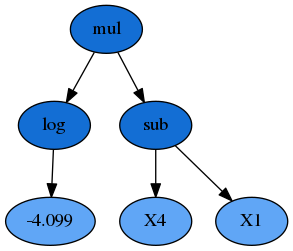

In [56]:
graph = pydotplus.graphviz.graph_from_dot_data(est_gp._program.export_graphviz())
Image(graph.create_png())

Above is best the formula that the GP came up with in 30 generations from a pool of 5000. Remember when you are looking at this, that you're in log space.
Reference, X{0:412, 1:443, 2:489, 3:510, 4:555, 5:670}.
Here the algorithm is tuned in to the fact that some kind of blue-green ratio matters. Interestingly, it is the inverse of the OCx formulation.

In [109]:
def PlotCompRegs(fieldChl,oc4Chl,gpChl):
    oc4Chl = np.log10(oc4Chl)
    rmse0 = sqrt(mean_squared_error(fieldChl, gpChl))
    rmse1 = sqrt(mean_squared_error(fieldChl, oc4Chl))
    f,axs = pl.subplots(ncols=2, figsize=(10,6),sharey=True)
    sb.regplot(gpChl, fieldChl, ax=axs[0])
    axs[0].set_xlim((-2,2)), axs[0].set_ylim((-2,2))
    axs[0].set_xlabel('log(chl) from GP fit', fontsize=16)
    axs[0].set_ylabel('log(chl) from data',fontsize=16)
    axs[0].plot([-2,2],[-2,2], 'k--', linewidth=2)
    axs[0].plot(0, 0, alpha=0, label='rmse=%.2f' % rmse0)
    axs[0].legend(loc='best', fontsize=16)
    sb.regplot(oc4Chl, fieldChl, ax=axs[1])
    axs[1].set_ylim((-2,2)), axs[1].set_xlim((-2,2))
    axs[1].set_ylabel('')
    axs[1].set_xlabel('log(chl) from OC4', fontsize=16)
    axs[1].plot([-2,2],[-2,2],'k--', linewidth=2);
    axs[1].plot(0, 0, alpha=0, label='rmse=%.2f' % rmse1)
    axs[1].legend(loc='best', fontsize=16)

In [106]:
def PlotCompHists(fieldChl, oc4Chl, gpChl):
    f,axs=pl.subplots(ncols=2,figsize=(12,6), sharey=True)
    axs[0].hist(fieldChl, bins=50, range=(-2,2), label='field chl',color='gray',
               normed=True);
    axs[0].hist(np.log10(oc4Chl), bins=50, range=(-2,2), label='OC4 chl',
                color='green', normed=True, alpha=0.3);
    axs[0].legend(fontsize=16)
    axs[1].hist(fieldChl, bins=50, range=(-2,2), label='field chl',color='gray',
               normed=True);
    axs[1].hist(gpChl, bins=50, range=(-2,2), label='GP chl', color='orange', alpha=0.3,
               normed=True);
    axs[1].legend(fontsize=16);
    axs[0].set_xlabel('log(chl)', fontsize=16)
    axs[0].set_ylabel('freq.')
    axs[1].set_xlabel('log(chl)', fontsize=16);

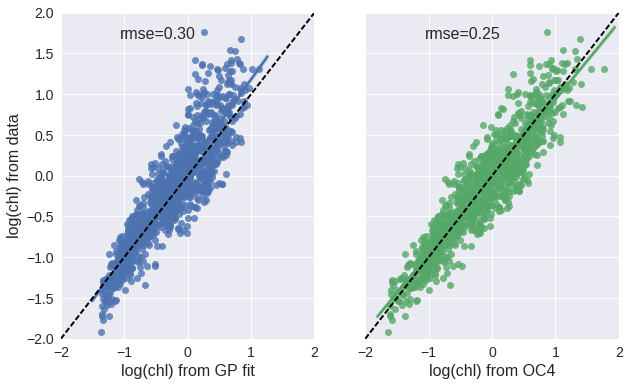

In [110]:
PlotCompRegs(fieldChl=y_train_log, oc4Chl=chlOC4_train, gpChl=chlGP_train_log)

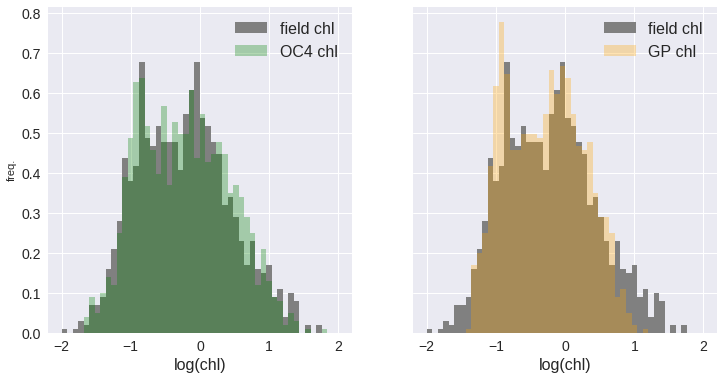

In [97]:
PlotCompHists(fieldChl=y_train_log, oc4Chl=chlOC4_train, gpChl=chlGP_train_log)

Now this is very interesting. The plot on the left suggest that the GP algorithm converged to a solution that fit the most frequently observed data. As a result it mimicks the field data quite well at values it is most frequently observed. As such it seem to deal with central values better than the OC4. A quick check is to compare an rmse for the two algorithms relative to the field data, with the entire data sets, and then with just some central values.

In [ ]:
oc4Msk = np.where(((np.log10(chlOC4_train)<=0.5) & (chlOC4_train>=-0.5)))

In [50]:
est_gp.score(X_test_log, y_test_log)

0.78662188880476536

In [67]:
#X_train comes from X, which was log transformed, so...
green = 555
maxBlueTestLog = X_test_log[[443, 489, 510]].max(axis=1)
chlOC4_test = OC4(maxBlueTestLog.values, X_test_log[green].values, log=True)

In [99]:
chlGP_test_log = est_gp.predict(X_test_log)

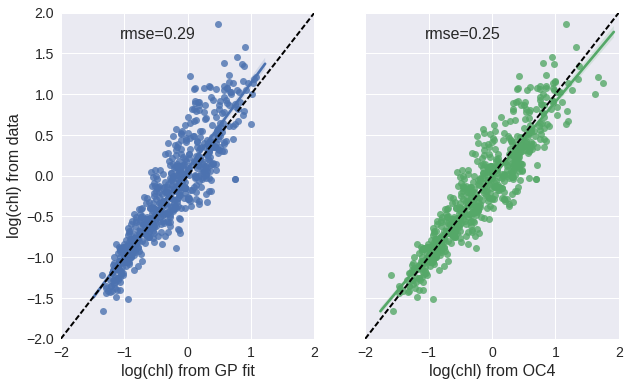

In [111]:
PlotCompRegs(fieldChl=y_test_log, oc4Chl=chlOC4_test, gpChl=chlGP_test_log)

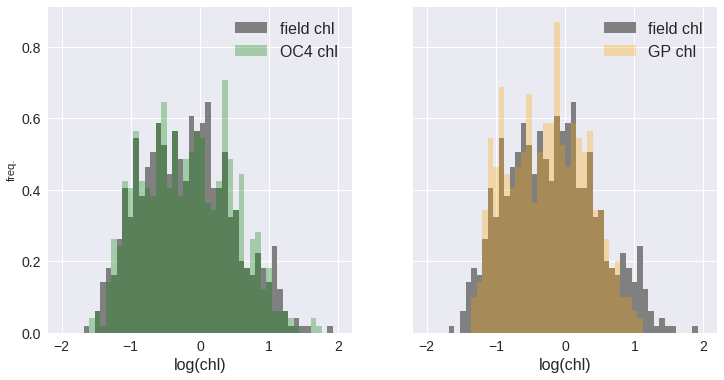

In [112]:
PlotCompHists(fieldChl=y_test_log, oc4Chl=chlOC4_test, gpChl=chlGP_test_log)